<h1>Logistic Regression</h1>
In this notebook, we will apply logistic regression (despite having regression in its name, it is a classification algorithm) on the same boston house dataset - we will convert it into a <strong>binary classification</strong> task.

1. We will look at hyper-parameter tuning during modelling.
2. The evaluation metrics (also loss functions) related to classification task, and their importance in gauging the model's performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

In [2]:
boston = load_boston()
df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
# changing the target: to convert it into a hypothetical classification algorithm
# say, if the PRICE > $300,000 then the house is considered expensive
# our classification task is to check if a house will be expensive/not by just looking at the features.
df['EXPENSIVE'] = boston['target']
df['EXPENSIVE'] = df['EXPENSIVE'].apply(lambda x: 'YES' if x>30 else 'NO')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,EXPENSIVE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,NO
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,NO
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,YES
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,YES
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,YES


<h1>Initial Data Analysis and Explanatory Data Analysis</h1>
Similar analysis holds as the <a href='linear_regression_2.ipynb'>previous notebook</a>, and the findings apply here too. We are omitting that part in this notebook but remember this is quite an important step for any ML task. Additionally, in this task, the class balance/imbalance of the target variable should also be checked.

In [3]:
print('Proportion of YES: {:.3f}%, Proportion of NO: {:.3f}%'.format(df[df['EXPENSIVE']=='YES']['EXPENSIVE'].count()*100/df.shape[0], df[df['EXPENSIVE']=='NO']['EXPENSIVE'].count()*100/df.shape[0]))
df['EXPENSIVE'].describe()

Proportion of YES: 16.601%, Proportion of NO: 83.399%


count     506
unique      2
top        NO
freq      422
Name: EXPENSIVE, dtype: object

<h1>Tasks</h1>

In a typical ML task, you actually should reflect here because of the class imbalance - 'Not Expensive' houses dominate the dataset. In an ideal dataset, you should generally  have equal proportion of 'YES' and 'NO' for a binary classification task. If not, you should at least try to resolve it [generating more samples, undersamplling the major class, oversampling the minor class, synthetically create more samples etc.] - all these without comprising the 'validity' of the data, i.e., throwing away important information [undersampling], introducing 'false information' inside the dataset [the way you introduced more samples, etc.]. This is quite an important part, and after completing this notebook, you should try to come back to this step, and may try to resolve this issue and evaluate the model's performance again.

For example, without any training, if an estimator just predicts the house as 'NOT EXPENSIVE' for any input, then the model's accuracy will be 83.399% for this dataset!!! Without resolving this imbalance, it is likely that the trained classifier may be inclined towards predicting the house to be 'NOT EXPENSIVE' too since this imbalance will impact its learning.

We will proceed with our <strong>binary classification task</strong> anyway without resolving this.

<h1>Modelling (with hyper-parameter tuning)</h1>

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter("ignore") # for GridSearchCV: some of its combination throws warning which is fine (they are not appropriate combination)

# dropping the EXPENSIVE column [target variable]
X = df.drop(['EXPENSIVE'], axis = 1)
#X = df[['RM']] # use/uncomment this line if you want to use a single feature!!!
y = df['EXPENSIVE'].apply(lambda x: 0 if x=='NO' else 1) # convering the categorical target into numeric: EXPENSIVE = 1, NOT EXPENSIVE = 0

# standardisation of the features: extremely important so that the effect of 'magnitude difference' between features do not affect the optimisation of weights are not given more importance
sc = StandardScaler()
X = sc.fit_transform(X)

# separating of training and testing set: 80-20 separation
# random_state parameter is given to keep the same randomised splitting: important when you are creating the model
# and want to keep a specific separation across multiple runs. Once modelling/evaluation is completed, you can actually
# remove this parameter to generate random splitting in each run of this notebook
# for classification, stratification on y [target] is important so that equal proportion of classes exist in both training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# hyper-parameter tuning using in-built GridSearchCV
# pipeline is used to standardisation and also creating the normal instance of a LogisticRegression
# This may take a while: good to set the max_iter parameter as well...
param_grid=[{'C': np.logspace(-4,4,15)},
           {'penalty': ['l1', 'l2']},
           {'solver': ['lbfgs', 'liblinear', 'adam']},
          {'max_iter': [10000]}]

lr = LogisticRegression()

# refer to sklearn documentation for more details:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv=10, scoring='recall', refit=True) # you can change scoring function that will impact the estimator
grid = grid.fit(X_train, y_train)
print('Best estimator: {}\nWeights: {}, Intercept: {}\nBest params: {}\nScorer: {}'.format(grid.best_estimator_, grid.best_estimator_.coef_, grid.best_estimator_.intercept_,grid.best_params_, grid.scorer_))
print('Available parameters for the estimator (fine-tuning): ',lr.get_params().keys())

Best estimator: LogisticRegression()
Weights: [[ 0.14513444  0.39202927 -0.97854289  0.1618424   0.02479979  1.47605734
   0.35606539 -0.67879687  0.95373518 -0.49196683 -0.73602807  0.1204218
  -2.43396895]], Intercept: [-4.37431992]
Best params: {'C': 1.0}
Scorer: make_scorer(recall_score, average=binary)
Available parameters for the estimator (fine-tuning):  dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


<h1>Evaluation</h1>

In [5]:
# model evaluation for training set
y_train_predict = grid.predict(X_train)
print("Training SET")
print("--------------------------------------")
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_train, y_train_predict), precision_score(y_train, y_train_predict), recall_score(y_train, y_train_predict), f1_score(y_train, y_train_predict)))
print("Confusion Matrix:\n {}".format(confusion_matrix(y_train, y_train_predict)))

# model evaluation for testing set
y_test_predict = grid.predict(X_test)

print("\nTesting SET")
print("--------------------------------------")
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_test, y_test_predict), precision_score(y_test, y_test_predict), recall_score(y_test, y_test_predict), f1_score(y_test, y_test_predict)))
print("Confusion Matrix:\n {}".format(confusion_matrix(y_test, y_test_predict)))

Training SET
--------------------------------------
Accuracy: 0.953, Precision: 0.853, Recall: 0.866, F1 Score: 0.859
Confusion Matrix:
 [[327  10]
 [  9  58]]

Testing SET
--------------------------------------
Accuracy: 0.961, Precision: 0.882, Recall: 0.882, F1 Score: 0.882
Confusion Matrix:
 [[83  2]
 [ 2 15]]


ROC AUC (Training)=0.981
ROC AUC (Testing)=0.982


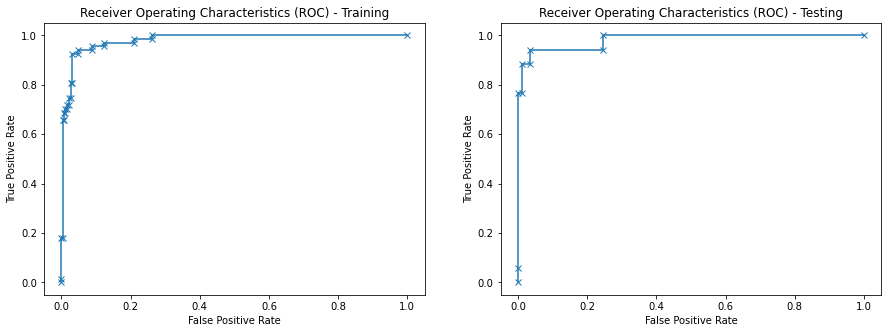

In [6]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
lr_probs_train = grid.predict_proba(X_train)
lr_probs_test = grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_train = lr_probs_train[:, 1]
lr_probs_test = lr_probs_test[:, 1]

print('ROC AUC (Training)={:.3f}'.format(roc_auc_score(y_train, lr_probs_train)))
print('ROC AUC (Testing)={:.3f}'.format(roc_auc_score(y_test, lr_probs_test)))

lr_fpr_train, lr_tpr_train, _ = roc_curve(y_train, lr_probs_train)
lr_fpr_test, lr_tpr_test, _ = roc_curve(y_test, lr_probs_test)

# plot the roc curve for the model
_ = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)
_ = ax1.plot(lr_fpr_train, lr_tpr_train, marker='x')
_ = ax1.set_title('Receiver Operating Characteristics (ROC) - Training')
_ = ax1.set_xlabel('False Positive Rate')
_ = ax1.set_ylabel('True Positive Rate')

ax2 = plt.subplot(122)
_ = ax2.plot(lr_fpr_test, lr_tpr_test, marker='x')
_ = ax2.set_title('Receiver Operating Characteristics (ROC) - Testing')
_ = ax2.set_xlabel('False Positive Rate')
_ = ax2.set_ylabel('True Positive Rate')

<h1>Conclusion</h1>

1. What do you feel about the model's performance looking at the various evaluation metrics?<br/>
2. Which metric can be considered as the estimator's performance indicator (accuracy/recall/precision/f1)?<br/>
2. Do change the 'scoring' metric of GridSearchCV to observe the changes in evaluaton metrics.<br/>
4. You should try to optimise the hyper-parameters of any ML algorithm for a given use-case - one simple example is provided here. EDA can provide valuable insights in terms of ideas of which hyper-parameters can be important.